<a href="https://colab.research.google.com/github/HoracioSoldman/PSO_ANN/blob/main/ANN_PSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing libraries

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

### Network initialization

In [2]:
#Network skeleton
network_config= {
    'inputs': 2,
    'hidden': {'layers': 5, 'neurons': 3},
    'outputs': 1
	}

#Loading data
function_name = "Sine"
f = open("./2in_complex.txt", 'r')
file_content = f.readlines()
f.close()

X = []
Y = []
pso_particles = []

for file_line in file_content:
	single_line = file_line.strip()
	#For some files the values are separated by tabulation (\t)
	values = np.array(single_line.split('\t'))
	#For some others the values are separated by empty space (" ")
	if len(values) == 1:
		values = np.array(single_line.split(' '))
	X.append(list(values[0:-1]))
	Y.append(list(values[-1:]))

print(X)
print(Y)

[['0.6771', '-0.4831'], ['-0.9142', '-0.9882'], ['0.1488', '0.4878'], ['0.6137', '0.2751'], ['-0.4975', '-0.7114'], ['0.3031', '0.8922'], ['0.6318', '0.8605'], ['-0.3801', '-0.4624'], ['0.0729', '-0.6734'], ['-0.578', '-0.5664'], ['0.3036', '-0.8944'], ['-0.5414', '0.3349'], ['-0.3781', '-0.3867'], ['0.4414', '0.9088'], ['-0.7377', '-0.8634'], ['-0.7495', '-0.6677'], ['0.8228', '-0.7275'], ['0.234', '-0.462'], ['-0.5587', '0.4258'], ['0.098', '0.8827'], ['-0.3403', '0.409'], ['0.8869', '0.1632'], ['0.7603', '0.4992'], ['-0.2408', '0.4511'], ['-0.6744', '0.9124'], ['-0.6075', '0.5524'], ['0.2266', '-0.6754'], ['-0.9379', '-0.4227'], ['0.9421', '0.901'], ['-0.5439', '0.9171'], ['0.3597', '-0.8901'], ['0.1997', '-0.2137'], ['-0.5693', '-0.6352'], ['-0.8465', '-0.9852'], ['0.5776', '-0.9644'], ['0.7559', '-0.2949'], ['0.4443', '0.9369'], ['-0.6887', '-0.6741'], ['-0.3732', '-0.9412'], ['-0.2847', '-0.9456'], ['0.5873', '0.9985'], ['-0.7795', '0.2452'], ['-0.7349', '-0.3799'], ['-0.7304', '

### Activation functions

In [3]:
#Sigmoid function, for the final output
def sigmoid(X):
    return 1 / (1 + np.exp(-X))
    

In [4]:
#Neuron activator
def activator(neuron, inputs):
  bias= 1
  activation= 0
  weights= neuron['weights']
  for i in range(len(weights)):
    activation += weights[i] * inputs[i]
    #add the bias
    return activation + bias

### Neural Network

In [5]:
class NNetwork():
	"""
	For each network object, we will have: 
		- "architecture" as the distribution of the weights in different neurons of layers in the ANN.
		- "position" as the list version of the weights in the ANN.
	"""
	def __init__(self, default_weights):
		self.position = []
		self.architecture = [] 
		self.mse = float('inf')
		weights = default_weights.copy()
		arch = list()
	
		#The first layer takes values from the input
		hidden_layer = [{'weights':[weights.pop(0) if len(weights) > 0 else random.random() for i in range(network_config['inputs'])]} \
		                for i in range(network_config['hidden']['neurons'])]
		arch.append(hidden_layer)
		#add weights for each hidden layer, excluding the first one (already processed above)
		if network_config['hidden']['layers'] > 1:
			for i in range(1, network_config['hidden']['layers']):
				layer = [{'weights':[weights.pop(0) if len(weights) > 0 else random.random() for i in range(network_config['hidden']['neurons'])]} \
				         for i in range(network_config['hidden']['neurons'])]
				arch.append(layer)
		#add weights to the output layer
		output_layer = [{'weights':[weights.pop(0) if len(weights) > 0 else random.random() for i in range(network_config['hidden']['neurons'])]} \
		                for i in range(network_config['outputs'])]
		arch.append(output_layer)
		self.architecture = arch
		
		if len(default_weights) > 0:
			self.position = default_weights.copy()
		else:
		 for layer in self.architecture:
			 for neuron in layer:
				 for weight in neuron['weights']:
					 self.position.append(weight)
			

	def instance_forwarding(self, inputs):
		for layer_index in range(len(self.architecture)):
			outputs=[]
			layer= self.architecture[layer_index]
			for neuron_index in range(len(layer)):
				neuron= layer[neuron_index]
				activation = activator(neuron, inputs)
				#we use sigmoid for the activation functions,
				neuron['output'] = sigmoid(activation)
				outputs.append(neuron['output'])
			inputs = outputs
		return inputs
	
	def feed_forward(self):
		squared_errors = 0
		for i in range(len(X)):
			input_Xi = []
			for x in X[i]:
				if len(x) > 0:
					input_Xi.append(float(x))
			output_Yi = float(Y[i][0])
	 		#feed forwarding with each instance
			output_yHat = self.instance_forwarding(input_Xi)
			if type(output_yHat) is list:
				output_yHat = output_yHat[0]
      #Calculate the mean squared error
			squared_errors = np.square(np.subtract(output_Yi, output_yHat))
			#saving the mean squared error
			mse = squared_errors/len(X)
			self.mse = mse
			#print('mse: ', self.mse)

		

### Particle

In [6]:
alpha = 0.5         # proportion of velocity 
beta = 0.3          # proportion of personal best 
gamma = 0.6         # proportion of the informants' best 
delta = 0.2         # proportion of global best 
epsilon = 0.5       # jump size of a particle

#Particle
class Particle():
  def __init__(self, position, mse, p_index):
    self.position = position
    self.particle_best_position = self.position
    self.particle_best_value = mse
    self.fitness = mse
    velocity = random.random()
    self.velocity = [velocity for i in range(len(position))]
    
    #particle_index will be used as the current particle's simple reference in the search_space
    #with this reference, we will be able to identify its informants (4 other particles)
    self.particle_index = p_index
    self.particle_informants_best_position = [float('inf') for i in range(len(self.position))]
    self.particle_informants_best_value = float('inf')

  def update_velocity(self, global_b_position):
    b = random.uniform(0,beta)
    c = random.uniform(0,gamma)
    d = random.uniform(0,delta)
    for i in range(len(self.position)):
      self.velocity[i] = (alpha * self.velocity[i])+ \
      (b * (self.particle_best_position[i] - self.position[i]))+ \
      (c * (self.particle_informants_best_position[i] - self.position[i]))+ \
      (d * (global_b_position[i] - self.position[i]))
      # #cognitive velocity
      # cognitive_velocity = (c1*random_r1) * (self.particle_best_position[i] - self.position[i])
      # #social velocity
      # social_velocity = (c2*random_r2) * (global_b_position[i] - self.position[i])
      # self.velocity[i] = (w*self.velocity[i]) + cognitive_velocity + social_velocity
      
      
  def move_particle(self):
    for i in range(len(self.position)):
      #here we update the position of the particle 
      self.position[i] = self.position[i] + (epsilon * self.velocity[i])
      #..we also need to update the fitness of the current particle as soon as possible

  def set_fitness(self, mse):
    self.fitness = mse
    if self.fitness < self.particle_best_value:
      self.particle_best_value = self.fitness
      self.particle_best_position = self.position
  
  def set_informants_best(self, pso_particles):
    """ 
      For each particle, we chose 4 closest(in indexes) ones as its informants.
    """
    informants = [pso_particles[(self.particle_index-2)%len(pso_particles)], \
                  pso_particles[(self.particle_index-1)%len(pso_particles)], \
                  pso_particles[(self.particle_index+1)%len(pso_particles)], \
                  pso_particles[(self.particle_index+2)%len(pso_particles)]]
    for informant in informants:
      if informant.particle_best_value < self.particle_informants_best_value:
        self.particle_informants_best_value = informant.particle_best_value
        self.particle_informants_best_position = informant.particle_best_position
    


### Particle Swarm Optimisation

In [7]:
#Search space
class SearchSpace():
  def __init__(self, particles):
    self.global_best_value = float('inf')
    self.global_best_position = []
    self.particles = particles
    
  def set_global_best(self):
      for particle in self.particles:
        if particle.particle_best_value < self.global_best_value:
            self.global_best_value = particle.particle_best_value
            self.global_best_position = particle.particle_best_position


### Operation

0: GLOBAL_BEST_ERROR: 0.012568803942192158
1: GLOBAL_BEST_ERROR: 0.01247782249031706
2: GLOBAL_BEST_ERROR: 0.012376963339124374
3: GLOBAL_BEST_ERROR: 0.012333290530087374
4: GLOBAL_BEST_ERROR: 0.012327258203099737
5: GLOBAL_BEST_ERROR: 0.012337265759678086
6: GLOBAL_BEST_ERROR: 0.012345635927144152
7: GLOBAL_BEST_ERROR: 0.012360648221348452
8: GLOBAL_BEST_ERROR: 0.012370355777824532
9: GLOBAL_BEST_ERROR: 0.012375270420182749
10: GLOBAL_BEST_ERROR: 0.012377730008380636
11: GLOBAL_BEST_ERROR: 0.012379244437841178
12: GLOBAL_BEST_ERROR: 0.012381028516901909
13: GLOBAL_BEST_ERROR: 0.01238528541487082
14: GLOBAL_BEST_ERROR: 0.01239103501276366
15: GLOBAL_BEST_ERROR: 0.012394214321193893
16: GLOBAL_BEST_ERROR: 0.012395954047681946
17: GLOBAL_BEST_ERROR: 0.012396587801810329
18: GLOBAL_BEST_ERROR: 0.012396210150093156
19: GLOBAL_BEST_ERROR: 0.01239549725421151
20: GLOBAL_BEST_ERROR: 0.012394134513332537
21: GLOBAL_BEST_ERROR: 0.012392564817874756
22: GLOBAL_BEST_ERROR: 0.012391321591973658
23

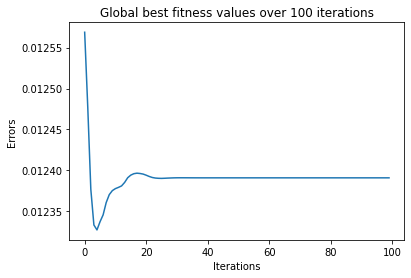

Optimized ANN for Sine function: [[{'weights': [0.8635658357348607, 1.0078334850699249]}, {'weights': [0.9910377412193005, 0.8856299366061626]}, {'weights': [1.0273705067867247, 0.6879205629269483]}], [{'weights': [0.811184996008505, 0.5855286515018343, 1.210890343949745]}, {'weights': [1.1270750731126835, 0.8056913655873398, 1.069101014558592]}, {'weights': [1.3331790138283708, 0.4957130977182956, 1.115122897630412]}], [{'weights': [0.6663911688412968, 1.150570930500013, 0.5752575563733726]}, {'weights': [0.9743619769836556, 0.8920059000891908, 0.7812798863217574]}, {'weights': [1.0063598597229653, 1.0210883206670318, 1.168301859169469]}], [{'weights': [1.1697659350793663, 1.0951424778720664, 1.240170261300899]}, {'weights': [1.1353272081587595, 0.7569310837439602, 0.5483074666261539]}, {'weights': [0.9104479341873198, 0.5515299692816045, 1.3095571265647292]}], [{'weights': [0.9266118098619924, 0.8396457356900456, 1.1415710994336004]}, {'weights': [0.8667807835579554, 0.54012196527602

In [10]:
#Operation

network_number = 10
networks = [NNetwork([]) for i in range(network_number)]

#Feed the networks then calculate their fitness values (the result of the mean squared errors)
for network in networks:
  network.feed_forward()

#Creating particles from fed_networks(the ones with our cost function: mse)
particles = [Particle(networks[i].position, networks[i].mse, i) for i in range(len(networks))]

#Adding the particles to a PSO
search_space = SearchSpace(particles)

iterations = 100
final_output_x = []
final_output_y = []

for i in range(iterations):
  #update the global best value using the freshly added particles in the search space
  search_space.set_global_best()

  #before we proceed to the particle update, we need to set its informants best first
  #as this variable is used in the velocity update
  for p in search_space.particles:
    p.set_informants_best(search_space.particles)
  
  for p in range(len(search_space.particles)):
    #we store the current particle inside a variable before making any change in it
    particle = search_space.particles[p]
    
    #start updating the particle
    particle.update_velocity(search_space.global_best_position)
    particle.move_particle()

    #update the network corresponding network with new weights(updated positions)
    updated_network = NNetwork(particle.position)

    #feedforward the updated network in order to get new mse value
    updated_network.feed_forward()

    #update the current/moved particle's fitness with the mse calculated above
    #this will also updated the particle best value&position in case of need
    particle.set_fitness(updated_network.mse)

    #update the same particle in the search_space
    #we use the index of this particle as its reference in the search_space
    search_space.particles[p] = particle

  #Update the values of informants best for each particle
  for particle in search_space.particles:
    particle.set_informants_best(search_space.particles)
  
  final_output_x.append(i)
  final_output_y.append(updated_network.mse)
  print(f"{i}: GLOBAL_BEST_ERROR: {updated_network.mse}")

#Ploting
plt.figure()
plt.plot(final_output_x, final_output_y)
plt.title(f"Global best fitness values over {iterations} iterations")
plt.xlabel("Iterations")
plt.ylabel("Errors")
plt.show()

best_ann = NNetwork(list(search_space.global_best_position)).architecture
print(f"Optimized ANN for {function_name} function: {best_ann}")


In [9]:
#Informants selections approach
""" 
  THis is just the approach on how we selected the informants for each particle
  For each particle, we chose 4 closest(in indexes) ones as its informants.
"""
number_nets = 10
nets = ['Net_'+str(i) for i in range(number_nets)]
for i in range(number_nets):
  net = nets[i]
  net_infs = [nets[(i-2)%number_nets], nets[(i-1)%number_nets], nets[(i+1)%number_nets], nets[(i+2)%number_nets]]
  print(f"Network:{net} | Informants: {net_infs}")

Network:Net_0 | Informants: ['Net_8', 'Net_9', 'Net_1', 'Net_2']
Network:Net_1 | Informants: ['Net_9', 'Net_0', 'Net_2', 'Net_3']
Network:Net_2 | Informants: ['Net_0', 'Net_1', 'Net_3', 'Net_4']
Network:Net_3 | Informants: ['Net_1', 'Net_2', 'Net_4', 'Net_5']
Network:Net_4 | Informants: ['Net_2', 'Net_3', 'Net_5', 'Net_6']
Network:Net_5 | Informants: ['Net_3', 'Net_4', 'Net_6', 'Net_7']
Network:Net_6 | Informants: ['Net_4', 'Net_5', 'Net_7', 'Net_8']
Network:Net_7 | Informants: ['Net_5', 'Net_6', 'Net_8', 'Net_9']
Network:Net_8 | Informants: ['Net_6', 'Net_7', 'Net_9', 'Net_0']
Network:Net_9 | Informants: ['Net_7', 'Net_8', 'Net_0', 'Net_1']
